# Wind Profile in Illinois

This notebook calculates an average hourly capacity factor for wind turbines in Illinois.

We use a reference wind farm, Railsplitter Wind Farm, located in Lincoln, IL. The data was provided
by the University of Illinois F\&S Department. UIUC has a power purchase agreement with Railsplitter Wind Farm.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']=16
plt.style.use('ggplot')

colors = {'spring':'tab:green',
          'summer':'tab:red',
          'fall':'tab:orange',
          'winter':'tab:blue'}

In [2]:
railsplitter_df = pd.read_csv("../railsplitter_data.csv", parse_dates=True, index_col='time')
railsplitter_df = pd.read_csv("../railsplitterHistories/RailSplitterHistories_1_pd.csv", parse_dates=True, index_col='time')
railsplitter_df.mw = railsplitter_df.mw*1000
railsplitter_df.rename(columns={'mw':'kw'}, inplace=True)
railsplitter_df

,kw
time,
2019-01-01 00:00:00,409.629030
2019-01-01 01:00:00,695.980661
2019-01-01 02:00:00,572.991406
2019-01-01 03:00:00,531.334902
2019-01-01 04:00:00,0.000000
...,...
2019-12-31 19:00:00,3045.063799
2019-12-31 20:00:00,2276.099912
2019-12-31 21:00:00,807.460258


In [3]:
hours_grouped = railsplitter_df.groupby(railsplitter_df.index.hour)

In [4]:
avg_hourly = np.zeros(len(hours_grouped))
std_hourly = np.zeros(len(hours_grouped))
for i, hour in enumerate(hours_grouped.groups):
    hour_data = hours_grouped.get_group(hour)
    avg_hourly[i] = hour_data.kw.mean()
    std_hourly[i] = hour_data.kw.std()

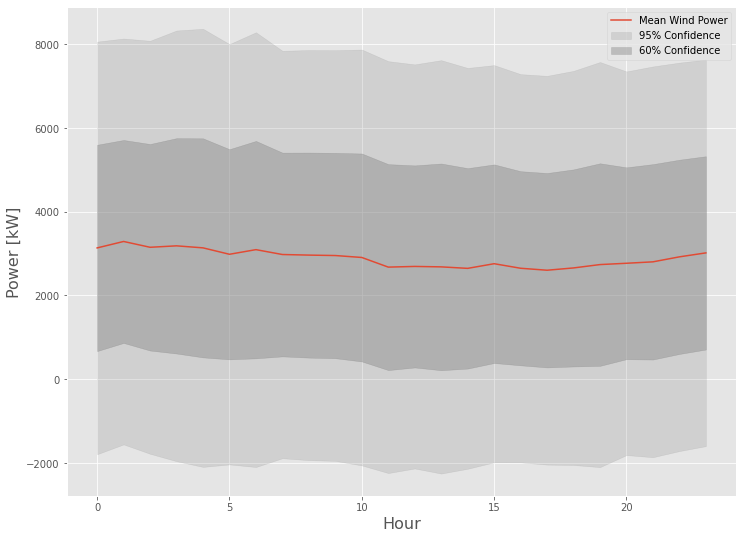

In [5]:
plt.figure(figsize=(12,9))
plt.plot(range(24), avg_hourly, label='Mean Wind Power')
plt.fill_between(range(24),
                 avg_hourly + 2 * std_hourly,
                 avg_hourly - 2 * std_hourly,
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(range(24),
                 avg_hourly + std_hourly,
                 avg_hourly - std_hourly,
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Power [kW]',fontsize=16)
# plt.savefig("../report/img/cap/wind_mean.png")
plt.show()

As expected, the uncertainty is huge. Wind can take on any value at any time and is difficult to predict. So let's just use the average value to generate our "profile."

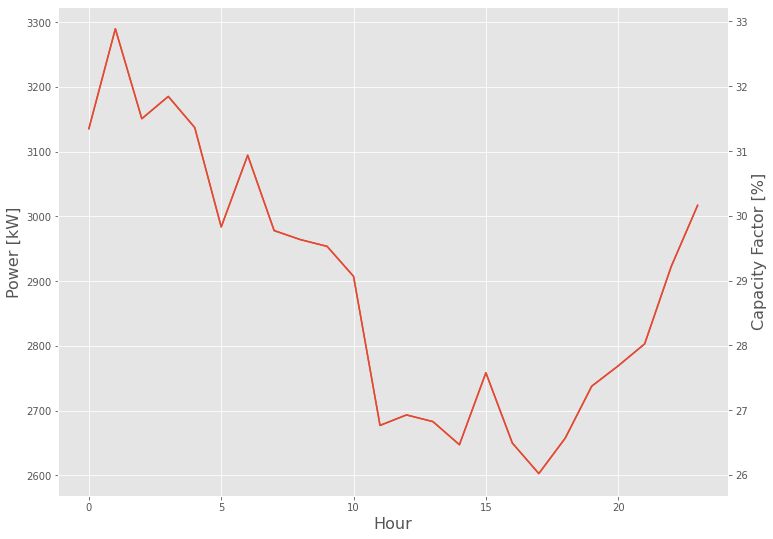

In [6]:
fig, ax = plt.subplots()
fig.figsize=(12,9)
ax.plot(range(24), avg_hourly, label='Mean Wind Power')
ax2 = ax.twinx()
ax2.plot(range(24), avg_hourly/railsplitter_df.kw.max()*100)
ax.set_xlabel('Hour',fontsize=16)
ax.set_ylabel('Power [kW]',fontsize=16)
ax2.set_ylabel('Capacity Factor [%]',fontsize=16)
plt.grid(which='major')
plt.show()
# fig.savefig("../report/img/cap/wind_cf.png")

In [7]:
avg_hourly.mean()/railsplitter_df.kw.max()

0.2890702773593118

In [8]:
for i, v in enumerate(avg_hourly):
    print(f"Hour {i+1} : {v/railsplitter_df.kw.max()} CF")

Hour 1 : 0.3134493326323019 CF
Hour 2 : 0.32886370263184384 CF
Hour 3 : 0.3149828695798412 CF
Hour 4 : 0.3184207789280634 CF
Hour 5 : 0.3136101269919514 CF
Hour 6 : 0.29827532926272593 CF
Hour 7 : 0.30934504234512744 CF
Hour 8 : 0.2977099076628016 CF
Hour 9 : 0.2963070107590105 CF
Hour 10 : 0.2952774079404813 CF
Hour 11 : 0.29064836909430136 CF
Hour 12 : 0.2676349687911516 CF
Hour 13 : 0.26925302838432646 CF
Hour 14 : 0.2682199612466282 CF
Hour 15 : 0.26465232806056244 CF
Hour 16 : 0.27576488071976785 CF
Hour 17 : 0.2649069837152538 CF
Hour 18 : 0.2601995774386714 CF
Hour 19 : 0.2656779357580182 CF
Hour 20 : 0.2736920455020765 CF
Hour 21 : 0.27682854560485 CF
Hour 22 : 0.2802244593869109 CF
Hour 23 : 0.2921378952512796 CF
Hour 24 : 0.3016041689355354 CF


## Seasonal Differences in Average Capacity Factor 

In [9]:
railsplitter_df

,kw
time,
2019-01-01 00:00:00,409.629030
2019-01-01 01:00:00,695.980661
2019-01-01 02:00:00,572.991406
2019-01-01 03:00:00,531.334902
2019-01-01 04:00:00,0.000000
...,...
2019-12-31 19:00:00,3045.063799
2019-12-31 20:00:00,2276.099912
2019-12-31 21:00:00,807.460258


In [10]:
spring_mask = (railsplitter_df.index.month >= 3) & (railsplitter_df.index.month <= 5) 
summer_mask = (railsplitter_df.index.month >= 6) & (railsplitter_df.index.month <= 8)
fall_mask = (railsplitter_df.index.month >= 9) & (railsplitter_df.index.month <= 11) 
winter_mask = (railsplitter_df.index.month == 12) | (railsplitter_df.index.month == 1) | (railsplitter_df.index.month == 2) 
seasons = {'spring':spring_mask,
           'summer':summer_mask,
           'fall':fall_mask,
           'winter':winter_mask}
seasonal_hourly_profile = {}

In [11]:
for season in seasons:
    mask = seasons[season]
    df = railsplitter_df[mask]
    hours_grouped = df.groupby(df.index.hour)
    
    avg_hourly = np.zeros(len(hours_grouped))
    std_hourly = np.zeros(len(hours_grouped))
    for i, hour in enumerate(hours_grouped.groups):
        hour_data = hours_grouped.get_group(hour)
        avg_hourly[i] = hour_data.kw.mean()
        std_hourly[i] = hour_data.kw.std()
        
    seasonal_hourly_profile[season] = avg_hourly
    colname = season+"_cf"
    seasonal_hourly_profile[colname] = avg_hourly/railsplitter_df.kw.max()

In [12]:
seasonal_df = pd.DataFrame(seasonal_hourly_profile)
seasonal_df

,spring,spring_cf,summer,summer_cf,fall,fall_cf,winter,winter_cf
0,3544.316859,0.354333,2309.310229,0.230867,3043.495569,0.304265,3654.616151,0.365360
1,3805.391159,0.380434,2581.678512,0.258096,3057.894540,0.305705,3720.071977,0.371904
2,3568.013473,0.356702,2548.238663,0.254753,2775.499116,0.277473,3719.339868,0.371831
3,3621.753575,0.362075,2451.875895,0.245120,2711.879640,0.271113,3966.701039,0.396560
4,3659.062164,0.365805,2384.561571,0.238390,2664.767820,0.266403,3849.856104,0.384879
5,3530.211390,0.352923,2197.989224,0.219738,2375.896879,0.237524,3842.285592,0.384122
6,3791.702130,0.379065,2104.660296,0.210408,2554.061878,0.255335,3939.305064,0.393821
7,3527.925270,0.352695,2099.050213,0.209847,2513.362148,0.251267,3783.830165,0.378278
8,3479.072145,0.347811,2208.378160,0.220777,2508.840650,0.250815,3669.672157,0.366866
9,3325.370409,0.332445,2235.058583,0.223444,2597.132790,0.259641,3668.475313,0.366746


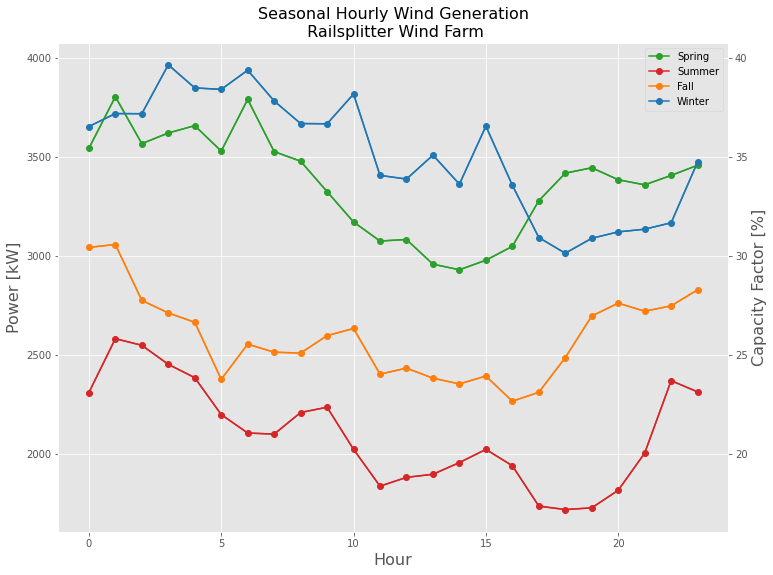

In [13]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
fig.figsize=(12,9)
for season in seasons:
    cf_key = season+"_cf"
    ax.plot(range(24), seasonal_df[season], label=season.capitalize(), color=colors[season], marker='o')
    ax2.plot(range(24), seasonal_df[cf_key]*100, color=colors[season])
ax.set_xlabel('Hour',fontsize=16)
ax.legend()
ax.set_ylabel('Power [kW]',fontsize=16)
ax2.set_ylabel('Capacity Factor [%]',fontsize=16)
ax.set_title('Seasonal Hourly Wind Generation\n Railsplitter Wind Farm',fontsize=16)
# fig.savefig("../report/img/cap/seasonal_hourly_wind.png")
plt.grid(which='major')

plt.show()